In [1]:
#!/usr/bin/python
# coding: latin-1
from __future__ import division
from __future__ import print_function

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 

%matplotlib inline
import matplotlib.pyplot as plt

import sys
import getopt

import fft8 as fft8 
import fdls as fdls
import ld_utils as utils

import fftfilt as fftfilt

pi = np.pi
tau = np.pi * 2

freq = (315.0 / 88.0) * 8.00
freq_hz = freq * 1000000.0

blocklen = (32 * 1024)  

lowpass_filter_b, lowpass_filter_a = sps.butter(8, (4.5/(freq/2)), 'low')



In [43]:
toread = 2000000

fd = open('PRE-sm-s4670.raw', 'rb')

inbuf = fd.read(toread)
indata = np.fromstring(inbuf, 'uint8', toread)


In [44]:
def fm_decode(hilbert, freq_hz):
	#hilbert = sps.hilbert(in_filt[0:hlen])
#	hilbert = sps.lfilter(hilbert_filter, 1.0, in_filt)

#	return hilbert.real

	# the hilbert transform has errors at the edges.  but it doesn't seem to matter much in practice 
	chop = 256 
	hilbert = hilbert[chop:len(hilbert)-chop]

	tangles = np.angle(hilbert) 
	dangles = np.diff(tangles)

	dangles2 = dangles % pi

	output = (dangles2 * (freq_hz / tau))

	return output


In [45]:
# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])

# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
)

Fhilbert = np.fft.fft(hilbert_filter, blocklen)

In [46]:
len(Fhilbert)

32768

In [77]:
Bbpf, Abpf = sps.butter(4, [1.2/(freq/2), 5.0/(freq/2)], btype='bandpass')
Fbpf = BA_to_FFT(Bbpf, Abpf, blocklen)

FiltV = Fhilbert * Fbpf

In [78]:
offset = 1500000
dataf = np.float32(indata[offset:offset + blocklen])

in_filt = np.fft.ifft(np.fft.fft(dataf,blocklen)*FiltV,blocklen)
output = fm_decode(in_filt, freq_hz)



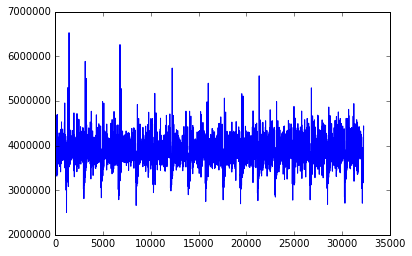

In [79]:
plt.plot(output)

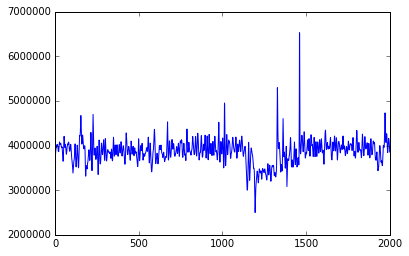

In [80]:
plt.plot(output[0:2000])